# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-12 20:10:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [           <=>      ] 201.24M  47.7MB/s    in 4.7s    

2023-10-12 20:10:24 (42.6 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


###### Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False


In [7]:
set_random_seed(123)

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
model = Ridge()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))

In [9]:
model.fit(x_train_scaled, y_train_scaled)
f"TEST -- {mean_squared_error(y_test, scaler_y.inverse_transform(model.predict(x_test_scaled)), squared=False)}\
 TRAIN -- {mean_squared_error(y_train, scaler_y.inverse_transform(model.predict(x_train_scaled)), squared=False)}"

'TEST -- 9.510160820470437 TRAIN -- 9.552822967970322'

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
best_rmse_metric = y_train.mean()
f"TEST -- {mean_squared_error(y_test, [best_rmse_metric] * len(y_test), squared=False)}\
 TRAIN -- {mean_squared_error(y_train, [best_rmse_metric] * len(y_train), squared=False)}"

'TEST -- 10.85246390513634 TRAIN -- 10.939755150678016'

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
#Целевая метрика - RMSE
model_lin = nn.Sequential(
    nn.Linear(X_train.shape[1],1)
)
test_rmse = []
train_rmse = []
test_mse = []
train_mse = []
x_train_lin = torch.tensor(x_train_scaled, dtype = torch.float32)
y_train_lin = torch.tensor(y_train, dtype = torch.float32)
x_test_lin = torch.tensor(x_test_scaled, dtype = torch.float32)
y_test_lin = torch.tensor(y_test, dtype = torch.float32)

lr = 0.1
for epoch in range(10):
  y_pred = model_lin(x_train_lin).squeeze()
  loss = torch.mean((y_train_lin - y_pred)**2)
  loss.backward()

  with torch.no_grad():
    for param in model_lin.parameters():
      param -= param.grad*lr

    y_pred_tr = model_lin(x_train_lin).squeeze()
    train_mse.append(torch.mean((y_train_lin - y_pred_tr)**2))
    train_rmse.append(train_mse[-1]**0.5)
    y_pred_test = model_lin(x_test_lin).squeeze()
    test_mse.append(torch.mean((y_test_lin - y_pred_test)**2))
    test_rmse.append(test_mse[-1]**0.5)

  model_lin.zero_grad()
  print(f'RMSE TEST -- {test_rmse[-1]}')

RMSE TEST -- 1598.876220703125
RMSE TEST -- 1279.1104736328125
RMSE TEST -- 1023.3311157226562
RMSE TEST -- 818.6732177734375
RMSE TEST -- 654.9969482421875
RMSE TEST -- 524.0128784179688
RMSE TEST -- 419.2867736816406
RMSE TEST -- 335.4581298828125
RMSE TEST -- 268.4693908691406
RMSE TEST -- 214.82699584960938


<ipython-input-12-c530c76b6b65>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[0][0].plot(train_mse,'-ok',color = 'r',)
<ipython-input-12-c530c76b6b65>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[1][0].plot(train_rmse,'-ok', color = 'g',)
<ipython-input-12-c530c76b6b65>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[1][1].plot(test_rmse,'-ok',color = 'y',)
<ipython-input-12-c530c76b6b65>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[0][1].plot(test_mse,'-ok', color = 'b',)


Text(0.5, 1.0, 'Test')

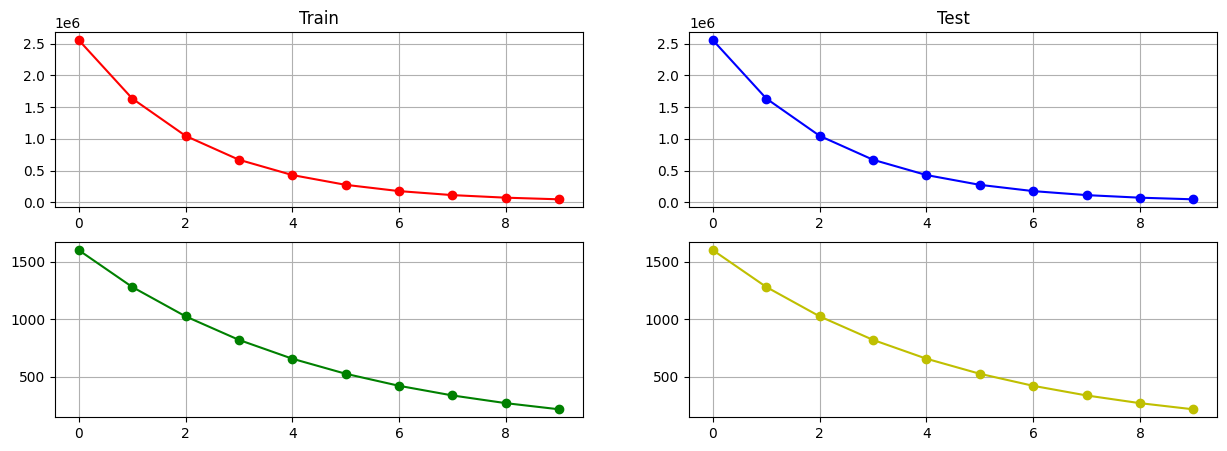

In [12]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
axs[0][0].grid(True)
axs[1][0].grid(True)
axs[0][1].grid(True)
axs[1][1].grid(True)
axs[0][0].plot(train_mse,'-ok',color = 'r',)
axs[1][0].plot(train_rmse,'-ok', color = 'g',)
axs[1][1].plot(test_rmse,'-ok',color = 'y',)
axs[0][1].plot(test_mse,'-ok', color = 'b',)
axs[0][0].set_title('Train')
axs[0][1].set_title('Test')

In [13]:
train_mse,test_mse

([tensor(2556186.),
  tensor(1635993.7500),
  tensor(1047071.2500),
  tensor(670160.6250),
  tensor(428937.7500),
  tensor(274554.8750),
  tensor(175749.7188),
  tensor(112514.3047),
  tensor(72043.5156),
  tensor(46142.0664)],
 [tensor(2556405.),
  tensor(1636123.7500),
  tensor(1047206.6250),
  tensor(670225.8750),
  tensor(429020.9688),
  tensor(274589.4688),
  tensor(175801.3906),
  tensor(112532.1562),
  tensor(72075.8125),
  tensor(46150.6367)])


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [14]:
class ToDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x).float().to(device)
        self.y = torch.tensor(y).float().to(device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, item):
        return self.x[item, :], self.y[item]

In [15]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))

X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [16]:
train_set = ToDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 256, shuffle=True) # 4096 - batch_size
test_set = ToDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 256, shuffle=False) # 4096 - batch_size
model = nn.Sequential(
    nn.BatchNorm1d(90),
    nn.Linear(90, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.BatchNorm1d(10),
    nn.ReLU(),
    nn.Linear(10, 1),
).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,cooldown = 2)
criterion = nn.functional.mse_loss

In [17]:
def train(model, optimizer, criterion, train_loader, test_loader, scaler, num_epochs=5):
  """
  params:
      model - torch.nn.Module to be fitted
      optimizer - model optimizer
      criterion - loss function from torch.nn
      train_loader - torch.utils.data.Dataloader with train set
      test_loader - torch.utils.data.Dataloader with test set
                    (if you wish to validate during training)
  """
  model.train()
  loss_test_mse = []
  loss_train_mse = []
  loss_test_rmse = []
  loss_train_rmse = []
  for i in range(num_epochs):
      #training
      model.train()
      for x_train, y_train in tqdm(train_loader):
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
      #evaluating
      model.eval()
      with torch.no_grad():
        #test metric
        loss_ret = []
        for x_test, y_test in tqdm(test_loader):
          y_test = y_test.to(torch.float)
          y_pred = model(x_test)
          y_pred = scaler.inverse_transform(y_pred.cpu().numpy())
          y_test = scaler.inverse_transform(y_test.cpu().numpy())
          loss1 = mean_squared_error(y_pred, y_test)
          loss_ret.append(loss1*len(y_test))
        loss_test_mse.append((np.sum(loss_ret)/len(test_loader.dataset.x)))
        loss_test_rmse.append(loss_test_mse[-1]**0.5)
        #train metric
        loss_ret = []
        for x_train, y_train in tqdm(train_loader):
            y_train = y_train.to(torch.float)
            y_pred = model(x_train)
            y_pred = scaler.inverse_transform(y_pred.cpu().numpy())
            y_train = scaler.inverse_transform(y_train.cpu().numpy())
            loss1 = mean_squared_error(y_pred, y_train)
            loss_ret.append(loss1*len(y_train))
        loss_train_mse.append((np.sum(loss_ret)/len(train_loader.dataset.x)))
        loss_train_rmse.append(loss_train_mse[-1]**0.5)
      print(f'Epoch {i}, RMSE test - {loss_test_rmse[-1]}')
      # if loss_test[-1] < 8.75:
        #   break
  return loss_test_mse,loss_test_rmse,loss_train_mse,loss_train_rmse

def test(model, criterion, test_loader,scaler):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    loss_ret = []
    model.eval()
    with torch.no_grad():
        for x_test, y_test in tqdm(test_loader):
            y_test = y_test.to(torch.float)
            y_pred = model(x_test)
            y_pred = scaler.inverse_transform(y_pred.cpu().numpy())
            y_test = scaler.inverse_transform(y_test.cpu().numpy())
            loss = mean_squared_error(y_pred, y_test)
            loss_ret.append(loss*len(y_test))
    return (np.sum(loss_ret)/len(test_loader.dataset.x))**0.5


In [18]:
loss_test_mse,loss_test_rmse,loss_train_mse,loss_train_rmse = train(model, optimizer, criterion, train_loader,test_loader, scaler_y,30)

  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 0, RMSE test - 8.827064418733672


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 1, RMSE test - 8.751401728587206


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 2, RMSE test - 8.716836570710347


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 3, RMSE test - 8.734644063310817


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 4, RMSE test - 8.803324503996858


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 5, RMSE test - 8.75447831517699


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 6, RMSE test - 8.865609481906832


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 7, RMSE test - 8.852026767173227


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 8, RMSE test - 8.853373620966927


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 9, RMSE test - 8.959456330890067


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 10, RMSE test - 8.93100075704029


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 11, RMSE test - 9.016953739296953


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 12, RMSE test - 8.996817637116065


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 13, RMSE test - 9.030128386863131


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 14, RMSE test - 9.06031668024239


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 15, RMSE test - 9.038021553717806


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 16, RMSE test - 9.12131261720292


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 17, RMSE test - 9.081040442793109


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 18, RMSE test - 9.05804647612351


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 19, RMSE test - 9.21972591051312


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 20, RMSE test - 9.1545664104759


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 21, RMSE test - 9.23575134810776


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 22, RMSE test - 9.206188789976856


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 23, RMSE test - 9.283719079444419


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 24, RMSE test - 9.262387318719828


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 25, RMSE test - 9.252246463419437


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 26, RMSE test - 9.222660378211854


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 27, RMSE test - 9.313849321352494


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 28, RMSE test - 9.419277792158626


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 29, RMSE test - 9.365165716445203


In [19]:
test(model, criterion, test_loader,scaler_y)

  0%|          | 0/202 [00:00<?, ?it/s]

9.365165716445203

In [20]:
test(model, criterion, train_loader,scaler_y)

  0%|          | 0/1812 [00:00<?, ?it/s]

6.49995951795253

<ipython-input-21-5222f1b1d0cb>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[0][0].plot(loss_train_mse,'-ok',color = 'r',)
<ipython-input-21-5222f1b1d0cb>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[1][0].plot(loss_train_rmse,'-ok', color = 'g',)
<ipython-input-21-5222f1b1d0cb>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[1][1].plot(loss_test_rmse,'-ok',color = 'y',)
<ipython-input-21-5222f1b1d0cb>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[0][1].plot(loss_test_mse,'-ok', color = 'b',)


Text(0.5, 1.0, 'Test')

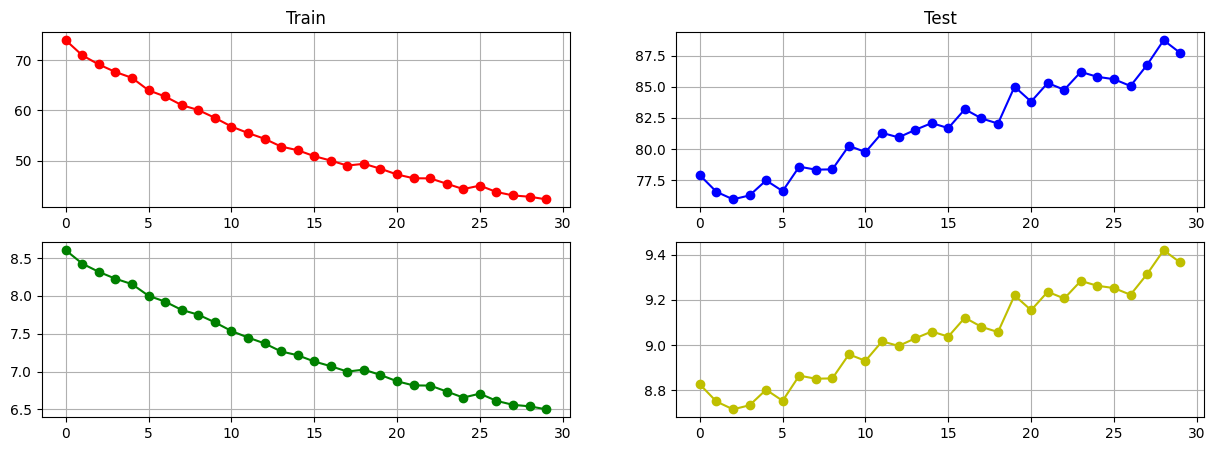

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
axs[0][0].grid(True)
axs[1][0].grid(True)
axs[0][1].grid(True)
axs[1][1].grid(True)
axs[0][0].plot(loss_train_mse,'-ok',color = 'r',)
axs[1][0].plot(loss_train_rmse,'-ok', color = 'g',)
axs[1][1].plot(loss_test_rmse,'-ok',color = 'y',)
axs[0][1].plot(loss_test_mse,'-ok', color = 'b',)
axs[0][0].set_title('Train')
axs[0][1].set_title('Test')

In [22]:
loss_test_rmse

[8.827064418733672,
 8.751401728587206,
 8.716836570710347,
 8.734644063310817,
 8.803324503996858,
 8.75447831517699,
 8.865609481906832,
 8.852026767173227,
 8.853373620966927,
 8.959456330890067,
 8.93100075704029,
 9.016953739296953,
 8.996817637116065,
 9.030128386863131,
 9.06031668024239,
 9.038021553717806,
 9.12131261720292,
 9.081040442793109,
 9.05804647612351,
 9.21972591051312,
 9.1545664104759,
 9.23575134810776,
 9.206188789976856,
 9.283719079444419,
 9.262387318719828,
 9.252246463419437,
 9.222660378211854,
 9.313849321352494,
 9.419277792158626,
 9.365165716445203]

In [23]:
model_drop = nn.Sequential(
    nn.BatchNorm1d(90),
    nn.Linear(90, 1000),
    nn.BatchNorm1d(1000),
    nn.LeakyReLU(),
    nn.Dropout(0.58),
    nn.Linear(1000, 500),
    nn.BatchNorm1d(500),
    nn.LeakyReLU(),
    nn.Dropout(0.55),
    nn.Linear(500, 400),
    nn.BatchNorm1d(400),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(400, 300),
    nn.BatchNorm1d(300),
    nn.LeakyReLU(),
    nn.Dropout(0.45),
    nn.Linear(300, 250),
    nn.BatchNorm1d(250),
    nn.LeakyReLU(),
    nn.Dropout(0.4),
    nn.Linear(250, 100),
    nn.BatchNorm1d(100),
    nn.LeakyReLU(),
    nn.Dropout(0.3),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(50, 10),
    nn.BatchNorm1d(10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.BatchNorm1d(5),
    nn.LeakyReLU(),
    nn.Linear(5, 1),
).to(device)
optimizer_drop = torch.optim.Adam(model_drop.parameters())

In [24]:
loss_test_mse,loss_test_rmse,loss_train_mse,loss_train_rmse = train(model_drop, optimizer_drop, criterion, train_loader,test_loader, scaler_y, 30)

  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 0, RMSE test - 8.901735919777488


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 1, RMSE test - 8.82179764657086


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 2, RMSE test - 8.824547130085001


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 3, RMSE test - 8.768955619143883


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 4, RMSE test - 8.765176816125464


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 5, RMSE test - 8.741422270586465


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 6, RMSE test - 8.73406112717422


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 7, RMSE test - 8.710624814300292


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 8, RMSE test - 8.723761005520084


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 9, RMSE test - 8.69856865472746


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 10, RMSE test - 8.683029468667495


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 11, RMSE test - 8.678499393413443


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 12, RMSE test - 8.688214519592155


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 13, RMSE test - 8.6779108241005


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 14, RMSE test - 8.685167215634566


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 15, RMSE test - 8.673220014008903


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 16, RMSE test - 8.667128078946611


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 17, RMSE test - 8.694266982792278


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 18, RMSE test - 8.687539384394931


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 19, RMSE test - 8.655097211152285


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 20, RMSE test - 8.652820125255259


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 21, RMSE test - 8.65837022747514


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 22, RMSE test - 8.688406123281553


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 23, RMSE test - 8.673103530650016


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 24, RMSE test - 8.66611724645632


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 25, RMSE test - 8.673975376693365


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 26, RMSE test - 8.667526457588906


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 27, RMSE test - 8.66455559334927


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 28, RMSE test - 8.738359136441817


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 29, RMSE test - 8.684671739943537


In [25]:
test(model_drop, criterion, test_loader,scaler_y)

  0%|          | 0/202 [00:00<?, ?it/s]

8.684671739943537

In [26]:
test(model_drop, criterion, train_loader,scaler_y)

  0%|          | 0/1812 [00:00<?, ?it/s]

8.048603206294489

<ipython-input-27-5222f1b1d0cb>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[0][0].plot(loss_train_mse,'-ok',color = 'r',)
<ipython-input-27-5222f1b1d0cb>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[1][0].plot(loss_train_rmse,'-ok', color = 'g',)
<ipython-input-27-5222f1b1d0cb>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[1][1].plot(loss_test_rmse,'-ok',color = 'y',)
<ipython-input-27-5222f1b1d0cb>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[0][1].plot(loss_test_mse,'-ok', color = 'b',)


Text(0.5, 1.0, 'Test')

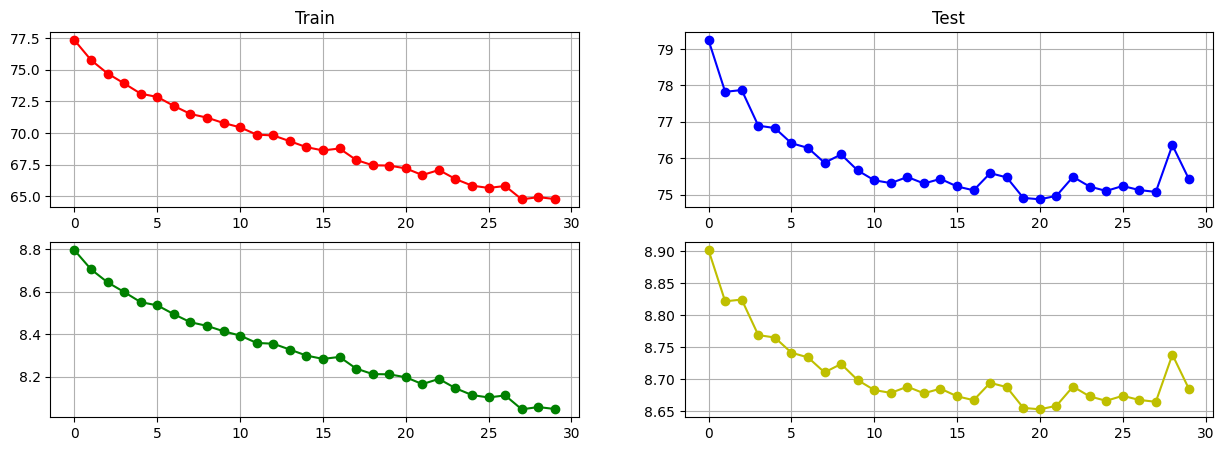

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
axs[0][0].grid(True)
axs[1][0].grid(True)
axs[0][1].grid(True)
axs[1][1].grid(True)
axs[0][0].plot(loss_train_mse,'-ok',color = 'r',)
axs[1][0].plot(loss_train_rmse,'-ok', color = 'g',)
axs[1][1].plot(loss_test_rmse,'-ok',color = 'y',)
axs[0][1].plot(loss_test_mse,'-ok', color = 'b',)
axs[0][0].set_title('Train')
axs[0][1].set_title('Test')

In [28]:
model_drop1 = nn.Sequential(
    nn.BatchNorm1d(90),
    nn.Linear(90, 1000),
    nn.BatchNorm1d(1000),
    nn.LeakyReLU(),
    nn.Linear(1000, 500),
    nn.BatchNorm1d(500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.BatchNorm1d(400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.BatchNorm1d(300),
    nn.LeakyReLU(),
    nn.Linear(300, 250),
    nn.BatchNorm1d(250),
    nn.LeakyReLU(),
    nn.Linear(250, 100),
    nn.BatchNorm1d(100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.LeakyReLU(),
    nn.Linear(50, 10),
    nn.BatchNorm1d(10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.BatchNorm1d(5),
    nn.LeakyReLU(),
    nn.Linear(5, 1),
).to(device)
optimizer_drop1 = torch.optim.Adam(model_drop1.parameters())

In [29]:
loss_test_mse,loss_test_rmse,loss_train_mse,loss_train_rmse = train(model_drop1, optimizer_drop1, criterion, train_loader,test_loader, scaler_y, 30)

  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 0, RMSE test - 8.856002842446076


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 1, RMSE test - 8.81057652230182


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 2, RMSE test - 8.717614787787317


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 3, RMSE test - 8.783066527270257


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 4, RMSE test - 8.766396075280191


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 5, RMSE test - 8.755201120700352


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 6, RMSE test - 8.836146669416307


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 7, RMSE test - 8.831048785850173


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 8, RMSE test - 8.934657958110858


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 9, RMSE test - 8.910546805475809


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 10, RMSE test - 9.00268931266466


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 11, RMSE test - 8.970930623260124


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 12, RMSE test - 9.271214647127403


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 13, RMSE test - 9.128388509035151


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 14, RMSE test - 9.177068132546978


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 15, RMSE test - 9.201857275628816


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 16, RMSE test - 9.359887412936166


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 17, RMSE test - 9.336732928142345


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 18, RMSE test - 9.335817482764256


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 19, RMSE test - 9.38016979613357


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 20, RMSE test - 9.447537485773102


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 21, RMSE test - 9.405180296949569


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 22, RMSE test - 9.557893942543704


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 23, RMSE test - 9.515861792356528


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 24, RMSE test - 9.459569581944779


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 25, RMSE test - 9.624002098210068


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 26, RMSE test - 9.6876492265186


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 27, RMSE test - 9.683996954183323


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 28, RMSE test - 9.811689324738941


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 29, RMSE test - 9.684902822600478


<ipython-input-30-5222f1b1d0cb>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[0][0].plot(loss_train_mse,'-ok',color = 'r',)
<ipython-input-30-5222f1b1d0cb>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[1][0].plot(loss_train_rmse,'-ok', color = 'g',)
<ipython-input-30-5222f1b1d0cb>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[1][1].plot(loss_test_rmse,'-ok',color = 'y',)
<ipython-input-30-5222f1b1d0cb>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  axs[0][1].plot(loss_test_mse,'-ok', color = 'b',)


Text(0.5, 1.0, 'Test')

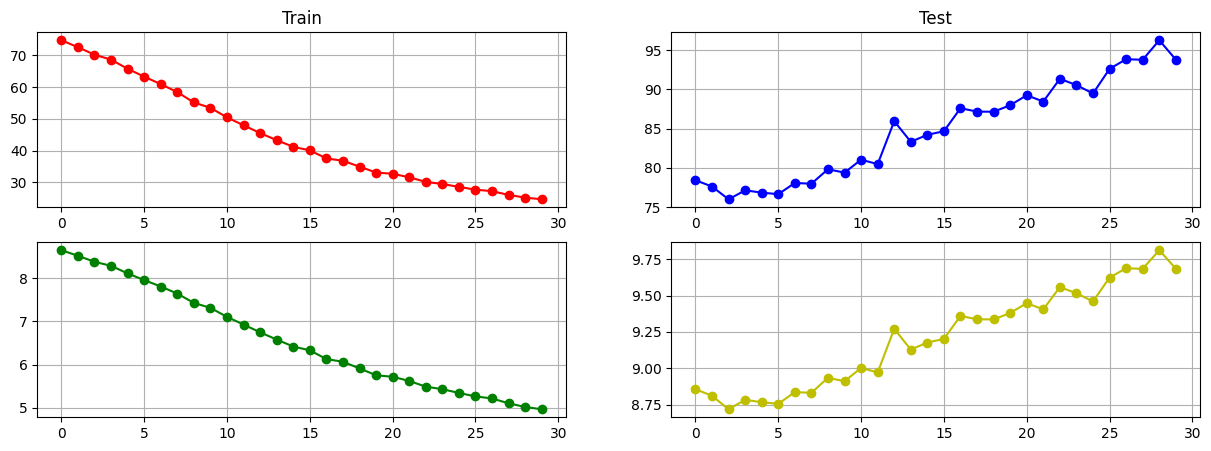

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
axs[0][0].grid(True)
axs[1][0].grid(True)
axs[0][1].grid(True)
axs[1][1].grid(True)
axs[0][0].plot(loss_train_mse,'-ok',color = 'r',)
axs[1][0].plot(loss_train_rmse,'-ok', color = 'g',)
axs[1][1].plot(loss_test_rmse,'-ok',color = 'y',)
axs[0][1].plot(loss_test_mse,'-ok', color = 'b',)
axs[0][0].set_title('Train')
axs[0][1].set_title('Test')

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

По 3 экспериментам с разными моделями заметно, что 2ая была самой удачной, т.к. практически вышла по эпохам со своей ошибкой на плато на тестовой выборке.
- Первая архитектура была слишком простая и даже имея регуляризацию в виде batch norm начала быстро переобучаться и подстравиться под гиперпараметры.
- 3я нейросеть аналогичная 2ой за исключением момента дропаута, он позволяет еще больше регуляризовывать работу нейросети -> ошибка на тестовой выборке уменьшается. 3ая нейросеть не обладает этим слоем -> начинает быстро подстраиваться под тренировочные данные.
- у 2ой нейросети есть регуляризация в виде batch norm и dropout, поэтому мы наблюдаем уменьшение ошибки и позже вывод ее на плато.

Я провел эксперименты с увеличением слоев нейронной сети, добавлением регуляризации и получилось, что лучшая модель показала результат в моменте 8.652820125255259 - RMSE, по завершении 30 эпох - 8.684671739943537.

Такая модель без dropout показала результат по завершении 30 эпох в 9.684902822600478 RMSE.

Модель с меньшим кол-вом слоев по завершении 30 эпох осталась на значении метрики RMSE в 9.365165716445203.

